In [104]:
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
import itertools 

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


F:\CodingForPython\Anaconda\envs\py37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда


2. Стабилизация дисперсии (при необходимости)


3. Выбор порядка дифференцирования


4. Выбор начальных приближений для $p, q, P, Q$.


5. Обучение и сравнение моделей-кандидатов, выбор победителя


6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p, q, P, Q$


7. Прогнозирование с помощью финальной модели.


Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [4]:
data = pd.read_csv(
    "WAG_C_M.csv",
    ";",
    index_col=['month'],
    parse_dates=['month'],
    dayfirst=True
)
data.rename(columns={"WAG_C_M":"salary"}, inplace=True)
data.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### <center> Визуальный анализ ряда

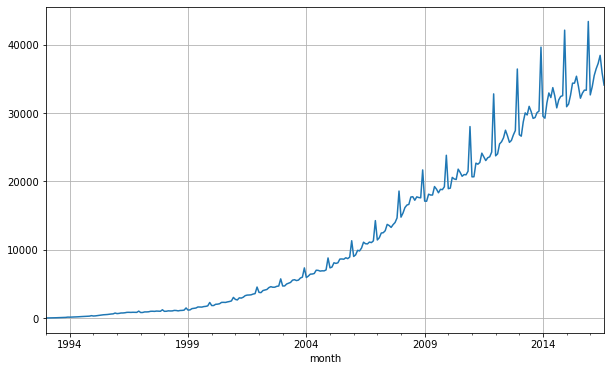

In [63]:
data.salary.plot(figsize=(10, 6), grid=True);

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1250x1250 with 0 Axes>

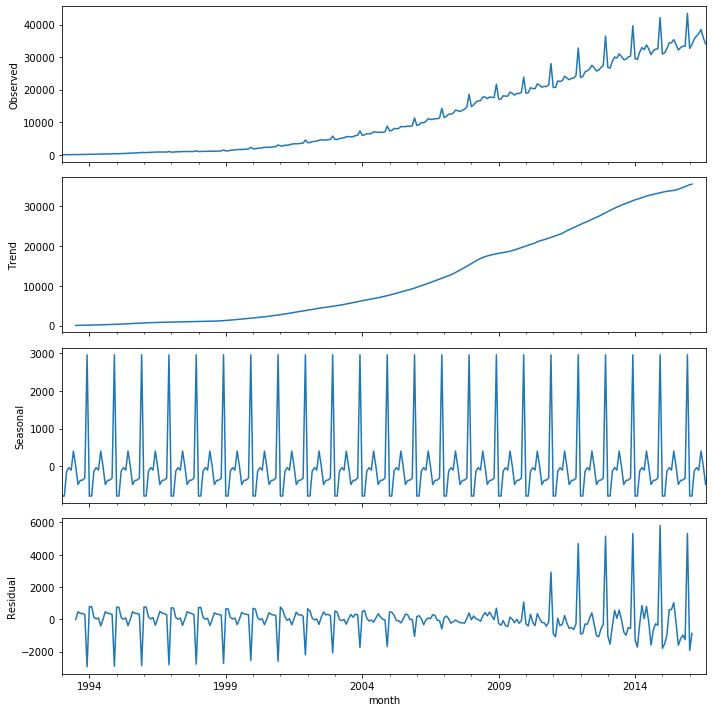

In [54]:
plt.figure(dpi=125);
sm.tsa.seasonal_decompose(data.salary).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1]);

#### p > 0.05 - нужны дополнительные преобразования, наблюдаем тренд и сезонность

### <center> Стабилизация дисперсии
  
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


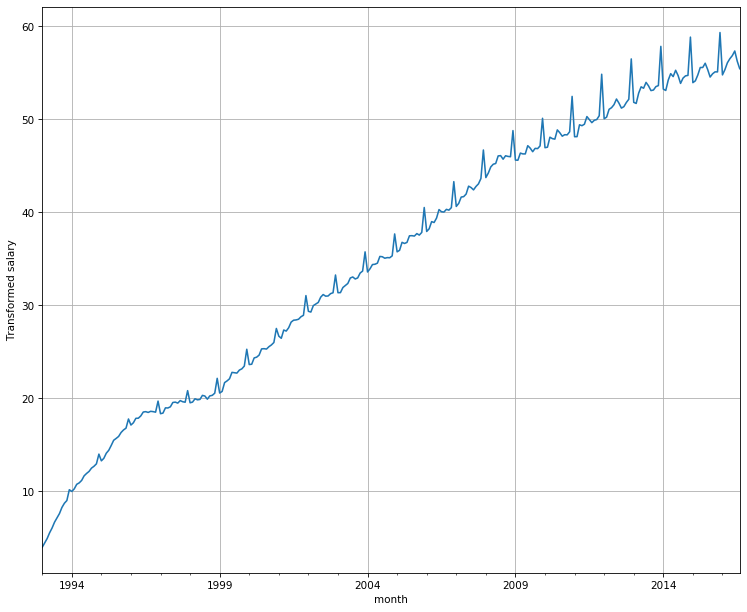

In [76]:
data['salary_boxcox'], lmbda = stats.boxcox(data.salary)
plt.figure(dpi=75)
data.salary_boxcox.plot(grid=True)
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_boxcox)[1])

#### p > 0.05 - нужны дополнительные преобразования

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд и выраженная годовая сезонность (12 месяцев). Попробуем **сезонное** дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 864x720 with 0 Axes>

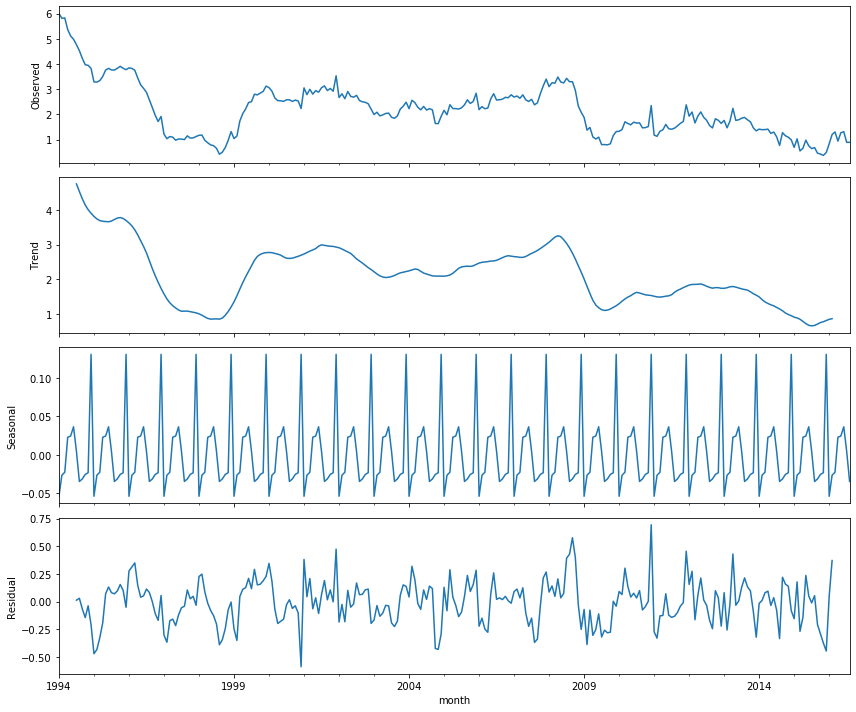

In [72]:
data['salary_box_diff'] = data.salary_boxcox - data.salary_boxcox.shift(12)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

p < 0.05 поэтому наш временной ряд можно назвать стационарным, но при этом тренд нельзя назвать константным. Попробуем дополнительное дифференцирование 

Критерий Дики-Фуллера: p = 5.2036037158222425e-08


<Figure size 864x720 with 0 Axes>

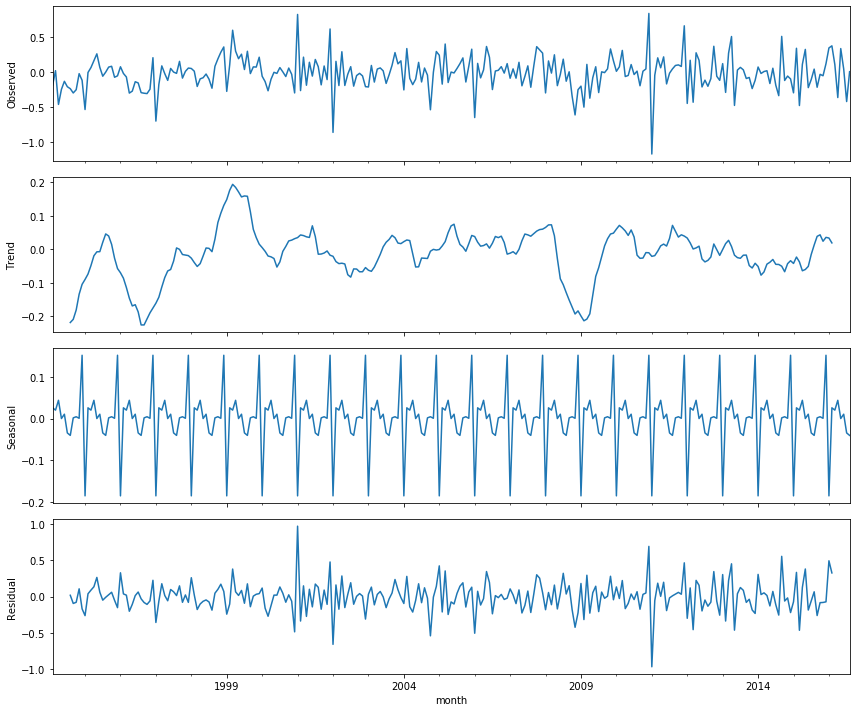

In [73]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

p value уменьшилось еще сильнее, тренд перестал быть выраженным.

## <center> Подбор модели

Посмотрим на ACF и PACF полученного ряда:

**Делаем либо dropna или срез массива [13:] !!!!**

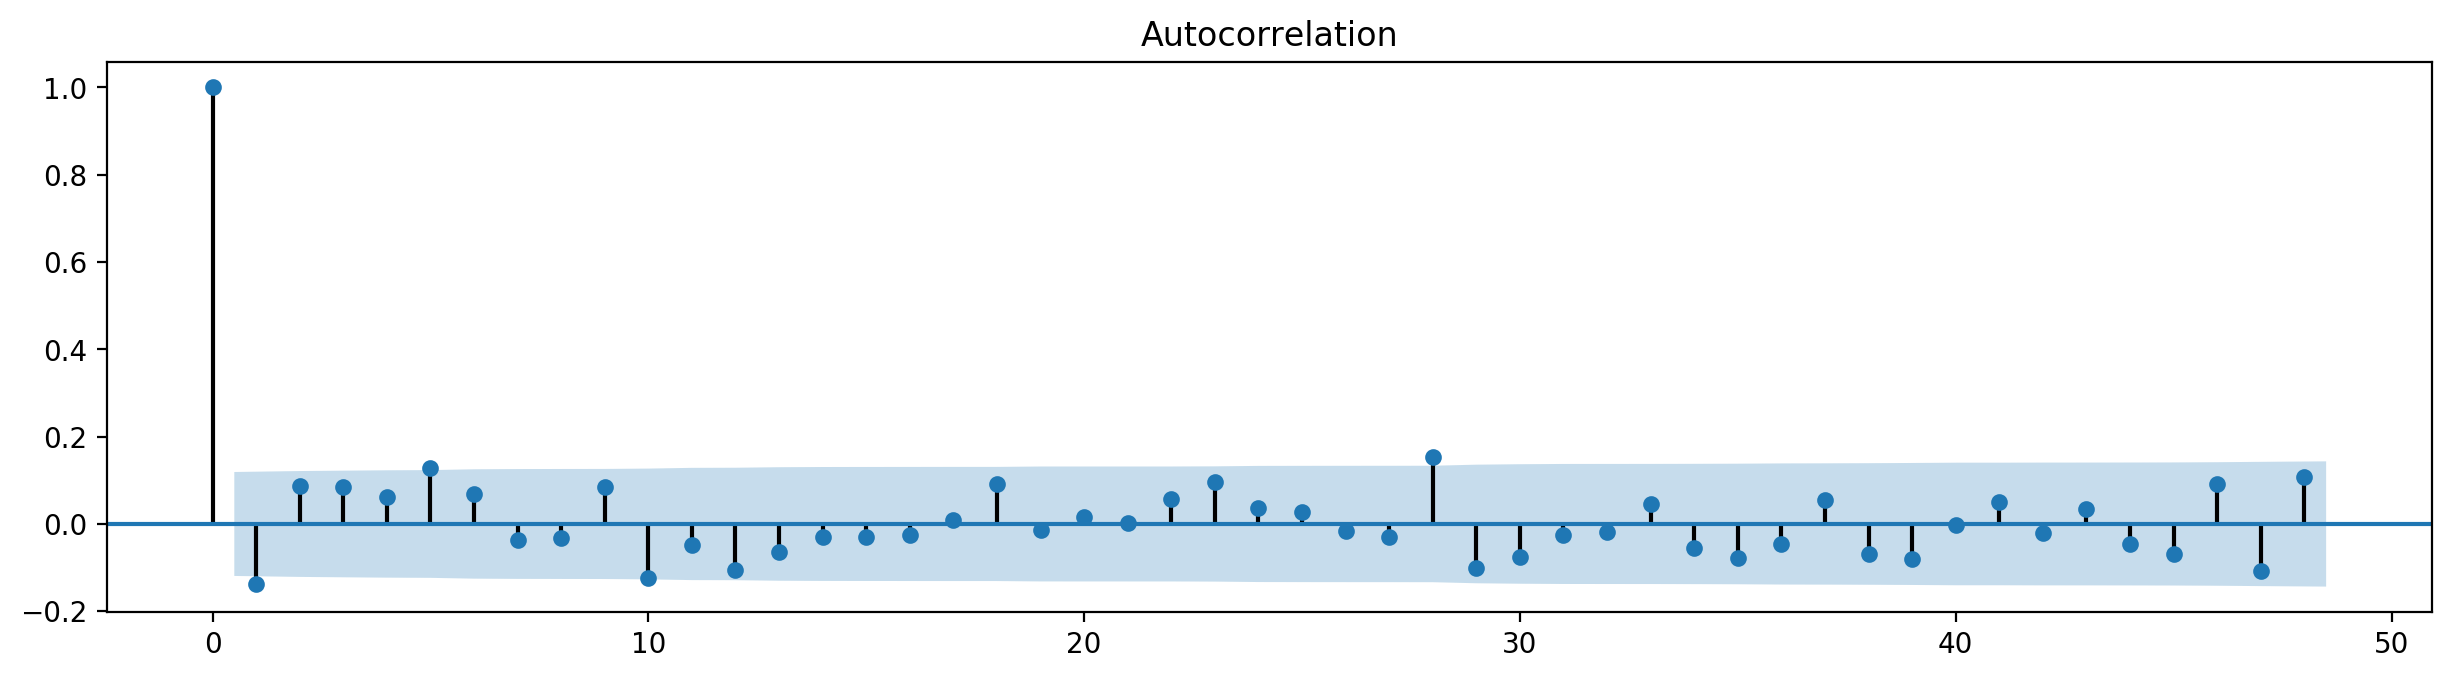

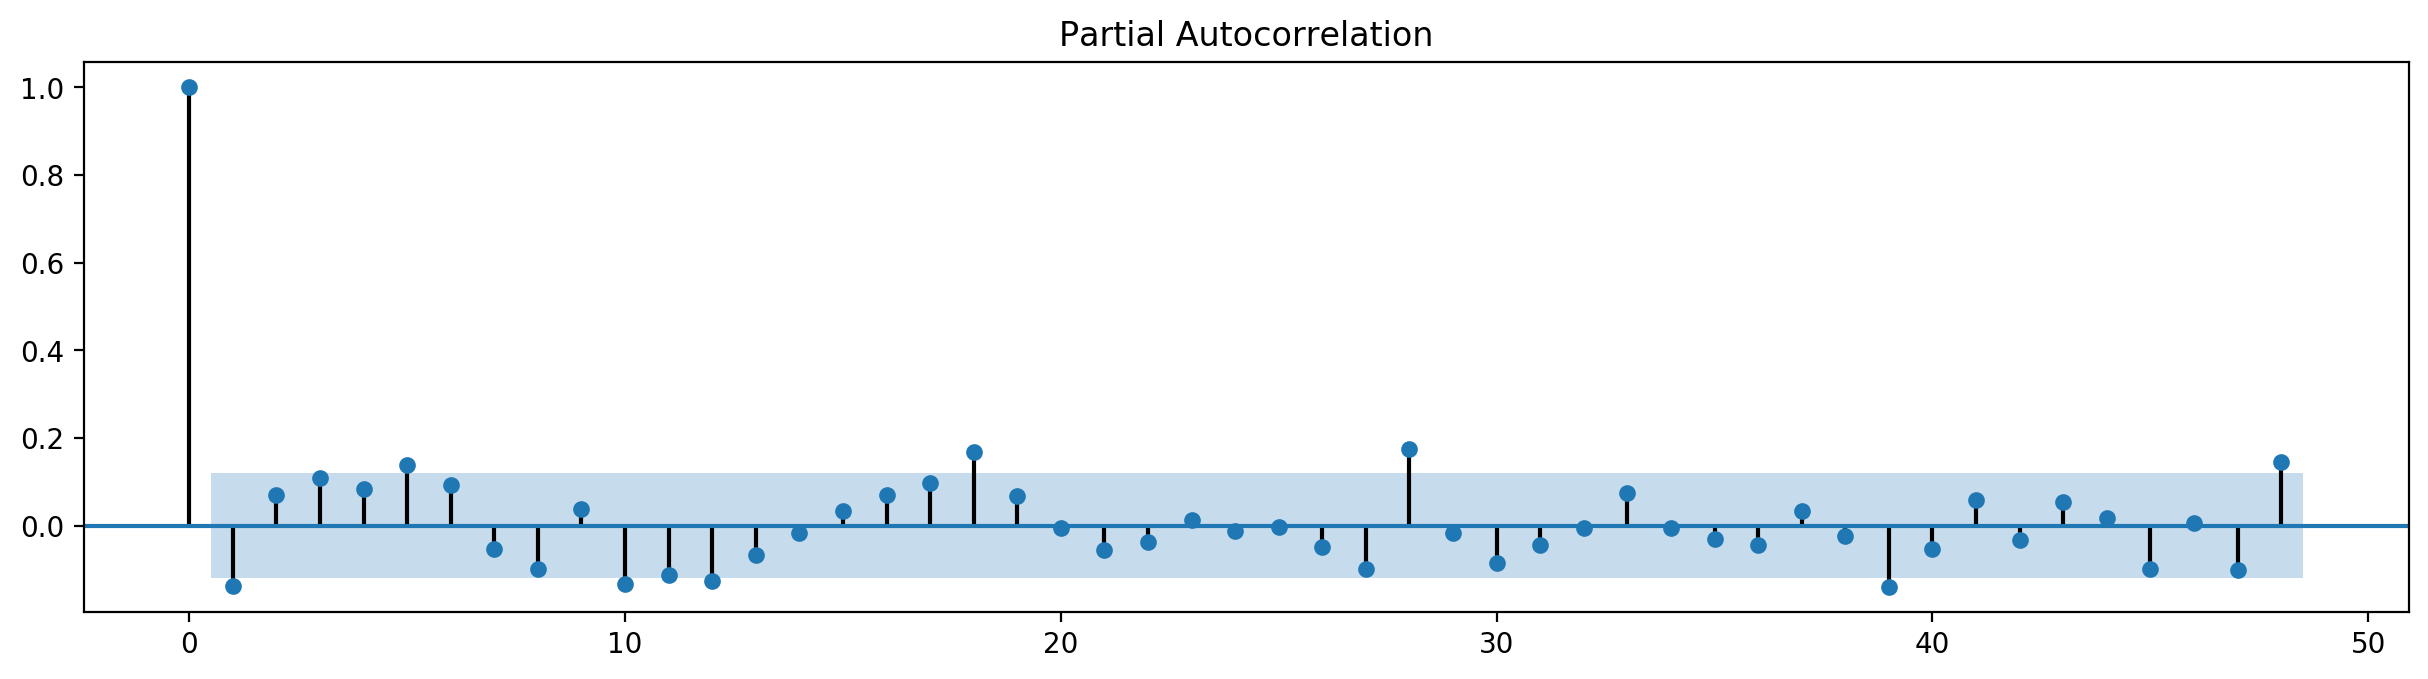

In [91]:
plt.figure(dpi=200)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

plt.figure(dpi=200)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

У подобных графиков довольно проблематично понять выше ли 0.05 значение или нет, которое находятся на грани.

### <center>Начальные приближения
Период у сезона = 12 (годичная сезонность)  
  
- Q = 0, т.к значимых сезонных значений нет (значения кратные 12)
- q = 10, т.к все значимые несезонные значения - 0, 1, 5, 10 (значение на грани), 28. НО в тестах нам писали что брать большие значения не стоит т.к. итоговая оптимизируемая функция - функция Акаике
- P = 4, т.к. значимое сезонное значение $P*S = 48$ -> $P = 4$. Другое возможное значение - 1.
- p = 10, т.к. все возможные значения - 0, 1, 10, 11 (на грани, поэтому не выбрал), 18, 28, 39.

In [109]:
list(range(0, 5)) + [10]

[0, 1, 2, 3, 4, 10]

In [110]:
ps = list(range(0, 5)) + [10]
d = 1
qs = list(range(0, 5)) + [10]
Ps = range(0, 5)
D = 1
Qs = range(0, 3)  # решил сделать поиск по Q тоже, т.к. ранее мы выбирали только приближения, а не конечный ответ

In [127]:
best_param

(2, 2, 4, 1)

In [120]:
parameters = list(itertools.product(ps, qs, Ps, Qs))
len(parameters)

540

In [194]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
i = 0
for param in parameters:
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    
    if i % 50 == 0:
        print(i)
    print(param, aic, end = " ||| ")
    
    results.append([param, model.aic])
    i += 1
    
warnings.filterwarnings('default')

Wall time: 0 ns


In [122]:
best = [best_model, best_param, best_aic]

**Принудительное завершение из-за очень долгого времени работы**

In [139]:
print(len(results))

338


In [121]:
print(best_model.summary())
print(best_param, best_aic)

                                 Statespace Model Results                                 
Dep. Variable:                      salary_boxcox   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(4, 1, 1, 12)   Log Likelihood                  23.891
Date:                            Wed, 22 Apr 2020   AIC                            -27.781
Time:                                    21:01:03   BIC                              8.240
Sample:                                01-01-1993   HQIC                           -13.319
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4717      0.066     22.179      0.000       1.342       1.602
ar.L2         -0.6607      0.074   

In [200]:
print("p = ", best[1][0])
print("q = ", best[1][1])
print("P = ", best[1][2])
print("Q = ", best[1][3])

p =  2
q =  2
P =  4
Q =  1


In [135]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
223  (2, 2, 4, 1) -27.781466
238  (2, 3, 4, 1) -26.444582
224  (2, 2, 4, 2) -25.828373
308  (3, 2, 2, 2) -25.253236
239  (2, 3, 4, 2) -24.385631


### <center>Анализ остатков

Критерий Стьюдента: p = 0.666489
Критерий Дики-Фуллера: p=  1.5869566387972808e-29


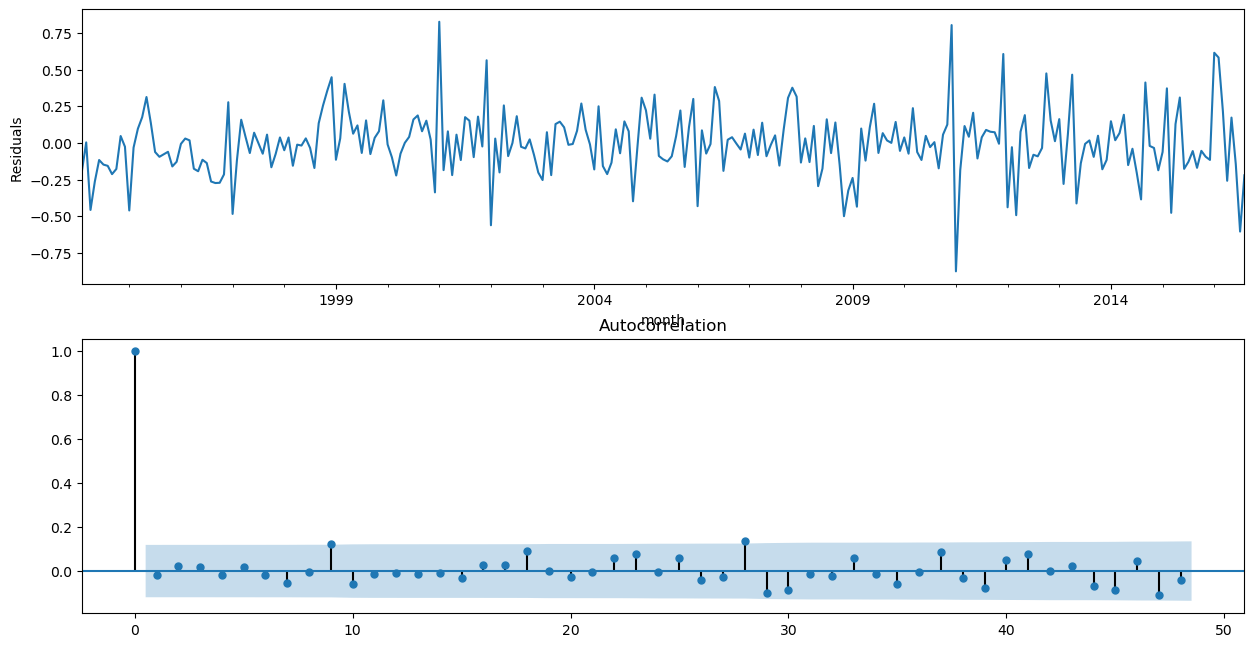

In [138]:
plt.figure(dpi=100)
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p = %f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p= ", sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

**Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).** 

Посмотрим, насколько хорошо модель описывает данные:

In [140]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

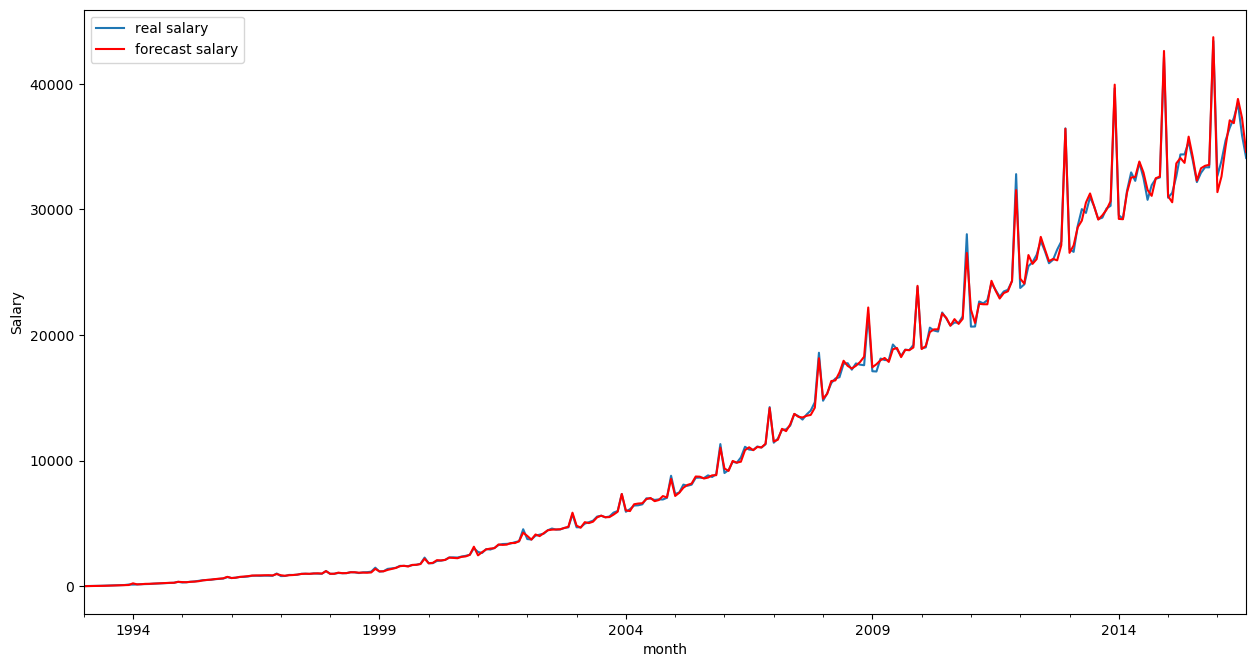

In [171]:
plt.figure(dpi=100)
data.salary.plot(label="real salary")
data.model.plot(color='r', label="forecast salary")
plt.ylabel('Salary')
plt.legend()
pylab.show()

## <center> Прогноз

In [180]:
data.shape

(284, 5)

In [185]:
data.tail(2)

,salary,salary_boxcox,salary_box_diff,salary_box_diff2,model
month,,,,,
2016-07-01,35888.0,56.260153,0.893671,-0.423323,37280.058023
2016-08-01,34095.0,55.455409,0.896620,0.002949,34580.177769


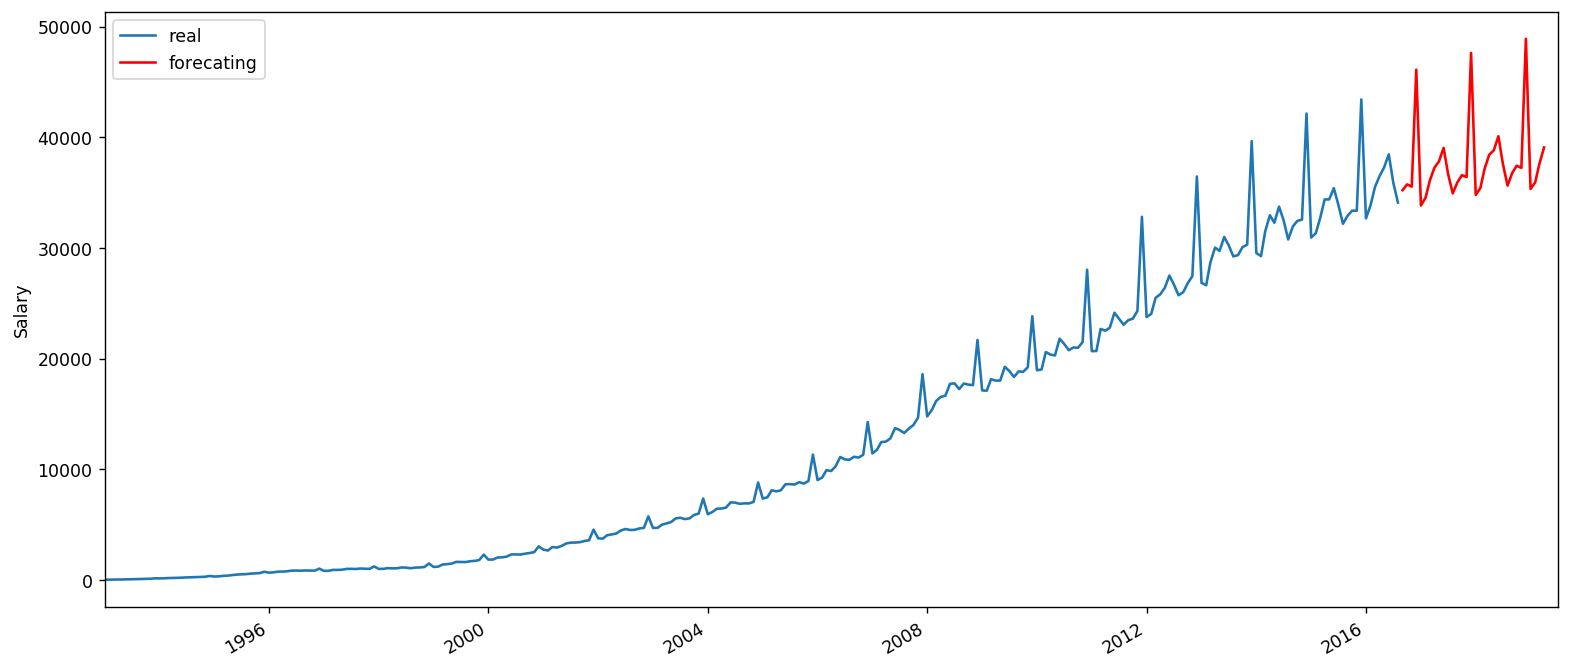

In [192]:
salary_2 = data[["salary"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary_2.columns)
salary_2 = pd.concat([salary_2, future])
salary_2['forecast'] = invboxcox(best_model.predict(start=284, end=315), lmbda)

plt.figure(dpi=125)
salary_2.salary.plot(label="real")
salary_2.forecast.plot(color='r', label="forecating")
plt.ylabel('Salary')
plt.legend()
pylab.show()